# Helper functions

In [142]:
from colour_system import *

def normalize_spectrum(file_path):
    
    #load in spectrum data from txt
    spec = np.genfromtxt(file_path)
    
    #truncate to visible range
    spec_trunc = spec[np.logical_and(spec[:,0]>=380,spec[:,0]<=780)]
    
    #normalize the spectrum with respect to area
    area = np.sum(spec_trunc[:,1][:-1]*np.diff(spec_trunc[:,0][:]))
    
    return spec_trunc[:,0],spec_trunc[:,1]/area

def rebin_spectrum(axis, spec, bins, bkg=None):
    
    #sort spectrum into cmf bins
    ind = np.digitize(axis,bins)
    
    mean_spec = np.zeros(len(bins))
    
    #if background is provided, subtract background
    if bkg:
        for i in range(1,len(bins)):
            cond = np.where(ind==i)
            mean_spec[i-1] = np.nanmean(spec[cond]-bkg[cond])
    
    #otherwise, just take the mean in each bin
    else:
        for i in range(1,len(bins)):
            cond = np.where(ind==i)
            mean_spec[i-1] = np.nanmean(spec[cond])
    
    return mean_spec

# Raw spectra

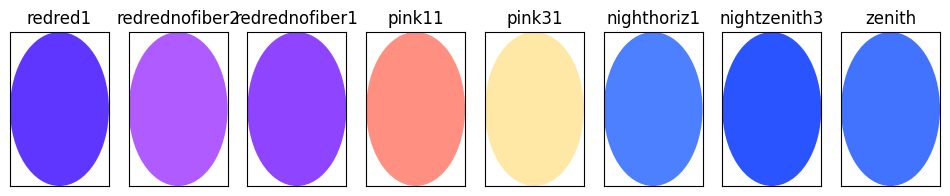

In [143]:
specs = ["redred1", 'redrednofiber2', 'redrednofiber1', "pink11",  'pink31', 'nighthoriz1','nightzenith3','zenith']
rgb_vals = [];

fig,ax = plt.subplots(1,len(specs),figsize=(12,2))

lam = np.arange(380.,781.,5)

cs = cs_srgb

for i in range(len(specs)):
    spec_name = './spectra/'+specs[i]+'.txt'
    
    axis, spec_norm = normalize_spectrum(spec_name)
    
    spec_mean = rebin_spectrum(axis,spec_norm,lam)
    
    html_rgb = cs.spec_to_rgb(spec_mean)
    rgb_vals.append(html_rgb)
    
    circle = Circle(xy=(0,0), radius=1, fc=html_rgb)
    
    ax[i].set_xlim(-1,1)
    ax[i].set_ylim(-1,1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(specs[i])
    
    ax[i].add_patch(circle)

In [144]:
np.savetxt("test_rgb_array", np.round(np.array(rgb_vals)*255), delimiter=",")

# Arbitrary correction
A correction for blue sky contamination done by eye.

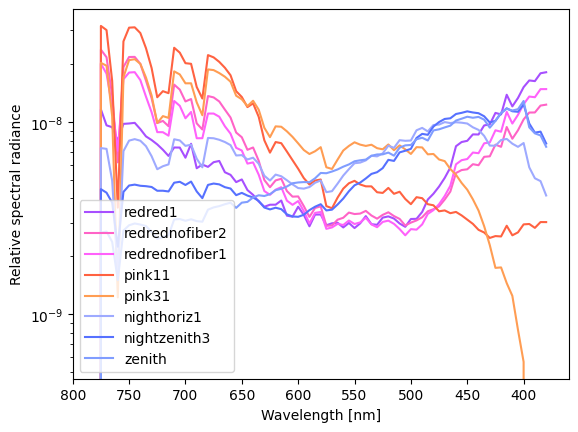

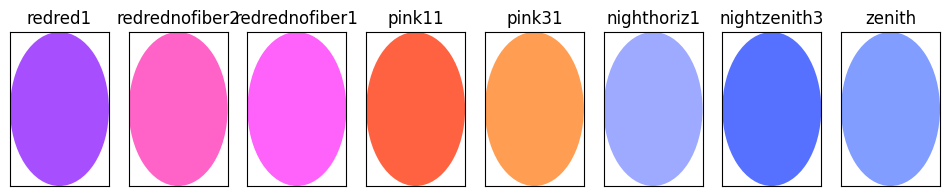

In [145]:
# plot all the spectra
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
scale_factor = (lam**-2)[::-1] # have to flip because numpy messes w the order
#scale_factor = 1
for i in range(len(specs)):
    spec_name = './spectra/'+specs[i]+'.txt'
    
    axis, spec_norm = normalize_spectrum(spec_name)
    
    
    spec_mean = rebin_spectrum(axis,spec_norm,lam)
    
    html_rgb = cs.spec_to_rgb(spec_mean*scale_factor, out_fmt='html')

    plt.plot(lam, spec_mean*scale_factor, color=html_rgb, label=specs[i])
    
ax.invert_xaxis()
ax.set_yscale('log')
ax.set_ylabel("Relative spectral radiance")
ax.set_xlabel("Wavelength [nm]")
ax.legend()

fig,ax = plt.subplots(1,len(specs),figsize=(12,2))
for i in range(len(specs)):
    spec_name = './spectra/'+specs[i]+'.txt'
    axis, spec_norm = normalize_spectrum(spec_name)
    
    spec_mean = rebin_spectrum(axis,spec_norm,lam)
    html_rgb = cs.spec_to_rgb(spec_mean*scale_factor, out_fmt='html')
    circle = Circle(xy=(0,0), radius=1, fc=html_rgb)
    
    ax[i].set_xlim(-1,1)
    ax[i].set_ylim(-1,1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(specs[i])
    
    ax[i].add_patch(circle)

# Subtract blue sky spectrum
Subtracting the Rayleigh-corrected blue sky spectrum

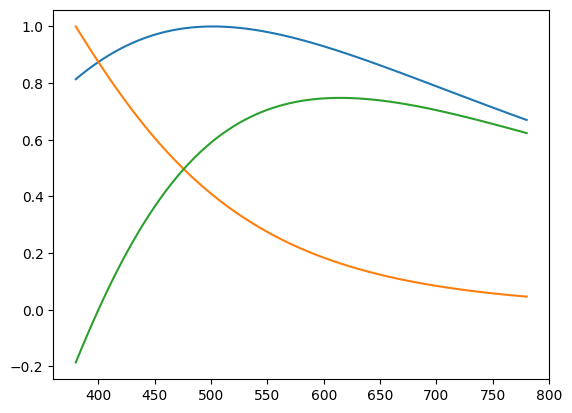

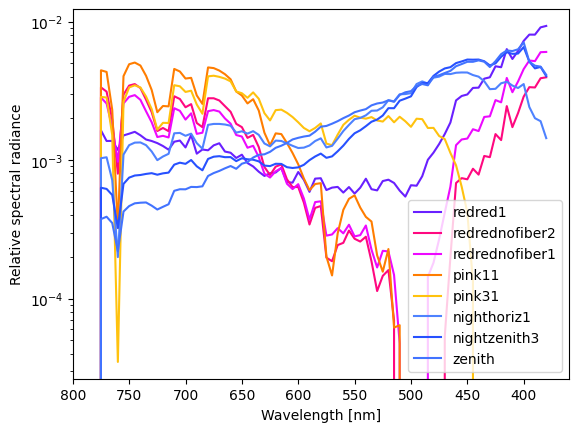

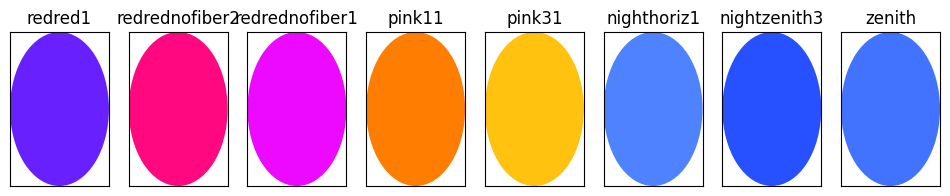

In [137]:
def planck(lam, T):
    """ Returns the spectral radiance of a black body at temperature T.

    Returns the spectral radiance, B(lam, T), in W.sr-1.m-2 of a black body
    at temperature T (in K) at a wavelength lam (in nm), using Planck's law.

    """

    lam_m = lam / 1.e9
    fac = h*c/lam_m/k/T
    B = 2*h*c**2/lam_m**5 / (np.exp(fac) - 1)
    return B

# rayleigh scattering
blue_sky = planck(lam, 5778)/lam**4 # blue sky with rayleigh scattering
blue_sky = blue_sky/max(blue_sky)

# ozone absorption
# TODO

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(lam, planck(lam, 5778)/max(planck(lam, 5778)))
plt.plot(lam, blue_sky)
plt.plot(lam, planck(lam, 5778)/max(planck(lam, 5778))-blue_sky)
plt.show()

# plot all the spectra
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
scale_factor = (lam**-2)[::-1] # have to flip because numpy messes w the order
scale_factor = 1

# Store the new rayleigh-corrected colors
rgb_vals = []

for i in range(len(specs)):
    spec_name = './spectra/'+specs[i]+'.txt'
    
    axis, spec_norm = normalize_spectrum(spec_name)
    
    spec_mean = rebin_spectrum(axis,spec_norm,lam)
    html_rgb = cs.spec_to_rgb(spec_mean-blue_sky*spec_mean[-2])
    rgb_vals.append(html_rgb)
    plt.plot(lam, spec_mean-blue_sky*spec_mean[-2], color=html_rgb, label=specs[i])
    
ax.invert_xaxis()
ax.set_yscale('log')
ax.set_ylabel("Relative spectral radiance")
ax.set_xlabel("Wavelength [nm]")
ax.legend()

fig,ax = plt.subplots(1,len(specs),figsize=(12,2))
for i in range(len(specs)):
    spec_name = './spectra/'+specs[i]+'.txt'
    axis, spec_norm = normalize_spectrum(spec_name)
    
    spec_mean = rebin_spectrum(axis,spec_norm,lam)
    html_rgb = cs.spec_to_rgb(spec_mean-blue_sky*spec_mean[-2])
    circle = Circle(xy=(0,0), radius=1, fc=html_rgb)
    
    ax[i].set_xlim(-1,1)
    ax[i].set_ylim(-1,1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(specs[i])
    
    ax[i].add_patch(circle)

In [138]:
np.savetxt("rayleigh_corrected_rgb_array", np.round(np.array(rgb_vals)*255), delimiter=",")

# Correcting for ozone
Subtracting the Rayleigh and ozone absorption-corrected blue sky

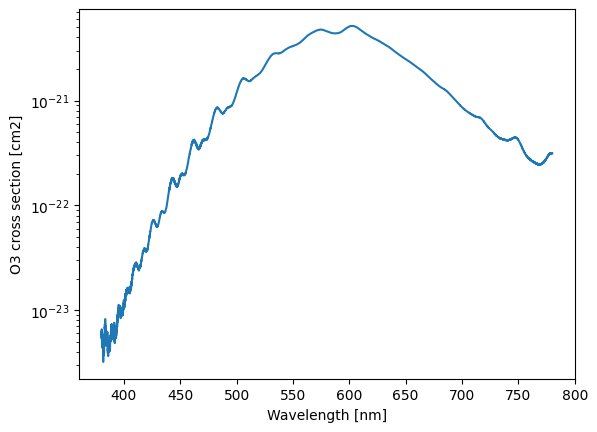

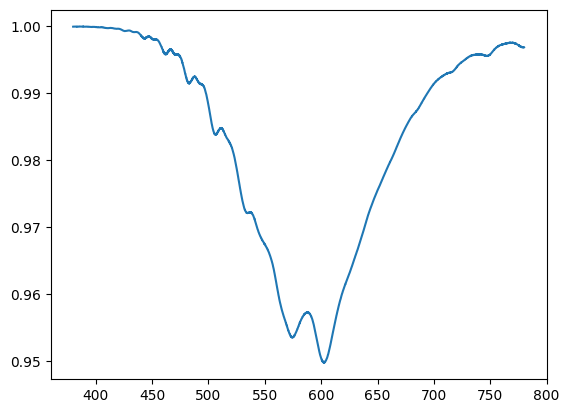

In [146]:
data = np.genfromtxt("./spectra/O3_cross_section_cut.dat")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(data[:,0], data[:,1])
ax.set_yscale("log")
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("O3 cross section [cm2]")

plt.show()

No3 = 1e19 # cm-2
a = 0.005 * (1/1e5)**4 # cm-2
so3 = data[:,1]

ozone_fine = np.exp(-No3*so3)
plt.plot(data[:,0], ozone_fine)

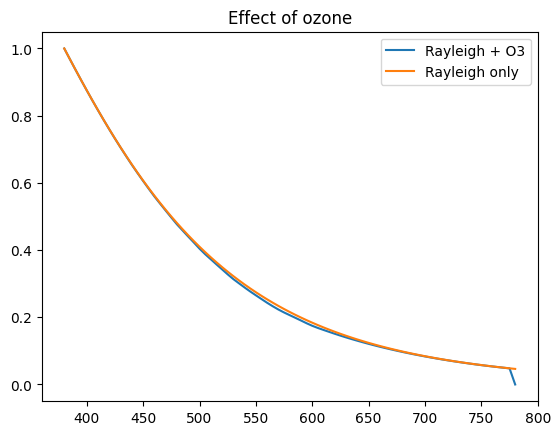

In [158]:
# The effect of ozone absorption is rather small on the blue sky
ozone = rebin_spectrum(data[:,0], ozone_fine, lam)

plt.title("Effect of ozone")
plt.plot(lam, blue_sky_o3, label="Rayleigh + O3")
plt.plot(lam, blue_sky, label="Rayleigh only")
plt.legend()